In [68]:
import numpy as np
import pandas as pd
import scipy.odr as odr

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import seaborn as sns

In [69]:
# Constants
x_data_color = sns.color_palette("Paired")[1]
x_fit_color = sns.color_palette("Paired")[5]

y_data_color = sns.color_palette("Paired")[3]
y_fit_color = sns.color_palette("Paired")[7]

In [70]:
# Defining some functions
def waist(params, z):
    w0, z0, M2 = params
    zR = np.pi*(w0**2)/wavelength
    return w0*np.sqrt(1+((z-z0)/zR)**2)

def initial_guess(x, y):
    z0 = x[np.argmin(y)]
    w0 = np.min(y)
    M20 = 1.05
    params = w0, z0, M20
    return params

# https://wormlabcaltech.github.io/mprsq/stats_tutorial/ODR.html
def perform_odr(x, y, xerr, yerr, beta0):
    fit_model = odr.Model(waist)
    mydata = odr.Data(x, y, wd=1./xerr, we=1./yerr)
    myodr = odr.ODR(mydata, fit_model, beta0=beta0)
    output = myodr.run()
    return output

In [71]:
header_end_row = 13
header = pd.read_excel('gaussian_beam_fit.xlsx', header=0, nrows=header_end_row, usecols=[0,1])
data = pd.read_excel('gaussian_beam_fit.xlsx', skiprows=header_end_row+1)

In [72]:
# Reading in fitting parameters
wavelength = header[header.Parameter == 'Wavelength [nm]']['Value'].values[0]
auto_guess = bool(header[header.Parameter == 'Auto Guess?']['Value'].values[0])
fit_M2x = bool(header[header.Parameter == 'Fit M^2_x?']['Value'].values[0])
fit_M2y = bool(header[header.Parameter == 'Fit M^2_y?']['Value'].values[0])
use_delta_z = bool(header[header.Parameter == 'Use Delta z?']['Value'].values[0])
use_delta_wx = bool(header[header.Parameter == 'Use Delta w_x?']['Value'].values[0])
use_delta_wy = bool(header[header.Parameter == 'Use Delta w_y?']['Value'].values[0])

# Rescale inputs to SI
wavelength *= (1E-9)

z = data['z [cm]']*(1E-2)
dz = data['Delta z [cm]']*(1E-2)

wx = data['w_0x [um]']*(1E-6)
dwx = data['Delta w_0x [um]']*(1E-6)

wy = data['w_0y [um]']*(1E-6)
dwy = data['Delta w_0y [um]']*(1E-6)

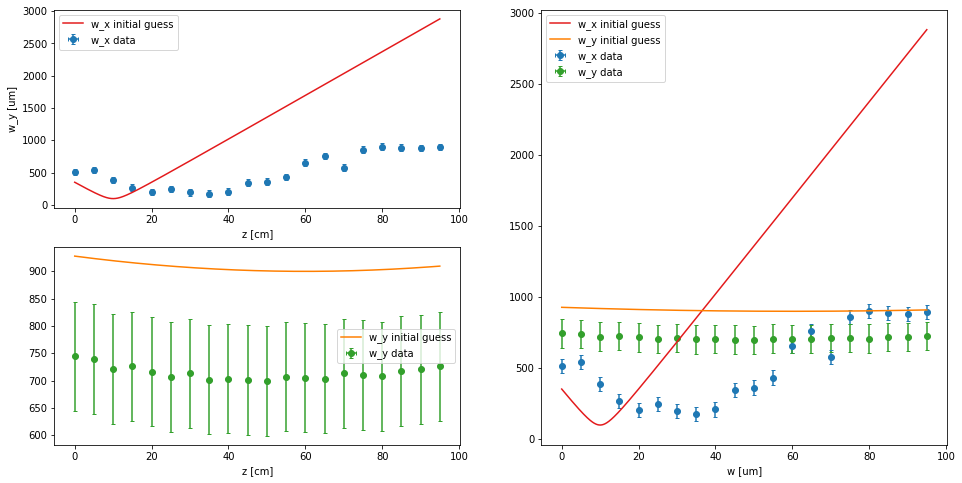

In [73]:
# Guess initial values
if auto_guess:
    # If using Auto Guess
    beta0x = initial_guess(z, wx)
    beta0y = initial_guess(z, wy)

else:
    # Use specified values
    w0x = header[header.Parameter == 'w_0x [um]']['Value'].values[0]*1E-6
    z0x = header[header.Parameter == 'z_0x [cm]']['Value'].values[0]*1E-2
    M20x = header[header.Parameter == 'M^2_x']['Value'].values[0]
    beta0x = [w0x, z0x, M20x]
    
    w0y = header[header.Parameter == 'w_0y [um]']['Value'].values[0]*1E-6
    z0y = header[header.Parameter == 'z_0y [cm]']['Value'].values[0]*1E-2
    M20y = header[header.Parameter == 'M^2_y']['Value'].values[0]
    beta0y = [w0y, z0y, M20y]

fig0 = plt.figure(figsize=(16, 8))

gs = fig0.add_gridspec(ncols=2, nrows=2)
ax0 = fig0.add_subplot(gs[0,0])
ax1 = fig0.add_subplot(gs[1,0], sharex=ax0)
ax2 = fig0.add_subplot(gs[:,1])

z_plot = np.linspace(min(z), max(z), 1000)

ax0.errorbar(z*1E2, wx*1E6, xerr=dz*1E2, yerr=dwx*1E6, fmt='o', capsize=2, zorder=1, label='w_x data', color=x_data_color)
ax0.plot(z_plot*1E2, waist(beta0x, z_fit)*1E6, zorder=2, label='w_x initial guess', color=x_fit_color)

ax1.errorbar(z*1E2, wy*1E6, xerr=dz*1E2, yerr=dwy*1E6, fmt='o', capsize=2, zorder=1, label='w_y data', color=y_data_color)
ax1.plot(z_fit*1E2, waist(beta0y, z_fit)*1E6, zorder=2, label='w_y initial guess', color=y_fit_color)

ax2.errorbar(z*1E2, wx*1E6, xerr=dz*1E2, yerr=dwx*1E6, fmt='o', capsize=2, zorder=1, label='w_x data', color=x_data_color)
ax2.errorbar(z*1E2, wy*1E6, xerr=dz*1E2, yerr=dwy*1E6, fmt='o', capsize=2, zorder=1, label='w_y data', color=y_data_color)
ax2.plot(z_plot*1E2, waist(beta0x, z_fit)*1E6, zorder=2, label='w_x initial guess', color=x_fit_color)
ax2.plot(z_fit*1E2, waist(beta0y, z_fit)*1E6, zorder=2, label='w_y initial guess', color=y_fit_color)

ax0.set_xlabel('z [cm]')
ax1.set_xlabel('z [cm]')
ax2.set_xlabel('z [cm]')

ax0.set_ylabel('w_x [um]')
ax0.set_ylabel('w_y [um]')
ax2.set_xlabel('w [um]')

ax0.legend()
ax1.legend()
ax2.legend()

plt.show()

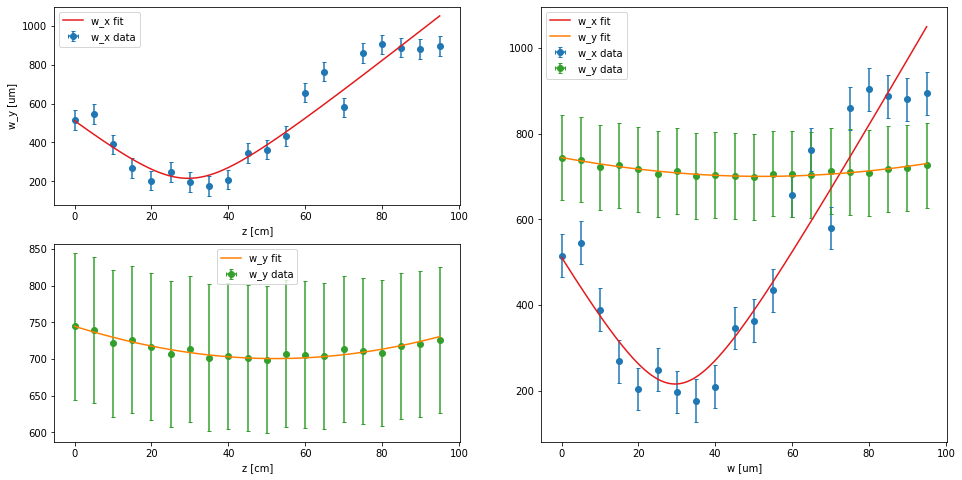

In [83]:
regressionx = perform_odr(z, wx, dz, dwx, beta0x)
betax = regressionx.beta

regressiony = perform_odr(z, wy, dz, dwy, beta0y)
betay = regressiony.beta

fig1 = plt.figure(figsize=(16, 8))

gs = fig1.add_gridspec(ncols=2, nrows=2)
ax0 = fig1.add_subplot(gs[0,0])
ax1 = fig1.add_subplot(gs[1,0], sharex=ax0)
ax2 = fig1.add_subplot(gs[:,1])

z_plot = np.linspace(min(z), max(z), 1000)

ax0.errorbar(z*1E2, wx*1E6, xerr=dz*1E2, yerr=dwx*1E6, fmt='o', capsize=2, zorder=1, label='w_x data', color=x_data_color)
ax0.plot(z_plot*1E2, waist(betax, z_fit)*1E6, zorder=2, label='w_x fit', color=x_fit_color)

ax1.errorbar(z*1E2, wy*1E6, xerr=dz*1E2, yerr=dwy*1E6, fmt='o', capsize=2, zorder=1, label='w_y data', color=y_data_color)
ax1.plot(z_fit*1E2, waist(betay, z_fit)*1E6, zorder=2, label='w_y fit', color=y_fit_color)

ax2.errorbar(z*1E2, wx*1E6, xerr=dz*1E2, yerr=dwx*1E6, fmt='o', capsize=2, zorder=1, label='w_x data', color=x_data_color)
ax2.errorbar(z*1E2, wy*1E6, xerr=dz*1E2, yerr=dwy*1E6, fmt='o', capsize=2, zorder=1, label='w_y data', color=y_data_color)
ax2.plot(z_plot*1E2, waist(betax, z_fit)*1E6, zorder=2, label='w_x fit', color=x_fit_color)
ax2.plot(z_fit*1E2, waist(betay, z_fit)*1E6, zorder=2, label='w_y fit', color=y_fit_color)

ax0.set_xlabel('z [cm]')
ax1.set_xlabel('z [cm]')
ax2.set_xlabel('z [cm]')

ax0.set_ylabel('w_x [um]')
ax0.set_ylabel('w_y [um]')
ax2.set_xlabel('w [um]')

ax0.legend()
ax1.legend()
ax2.legend()

plt.show()

In [86]:
print(betax)
print(betay)

[2.15730174e-04 2.95440661e-01 1.10000000e+00]
[7.00489324e-04 5.21763996e-01 1.10000000e+00]
